[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nadegecorbin/MESE_MOCO_traj/blob/master/Trajectory_MESE_MOCO.ipynb)

In [1]:
# %% Purpose: generate the trajectory of the k-space sampling 
# of the 3D radial multi-echo spin-echo sequence
# with motion correction and acceleration capabilities
#
# Note that this code is not optimized
# for the python language but rather matches the C++ implementation 
# required for the Siemens sequence. 
# The only difference with the C++ implementation is the "random.shuffle" fonction 
# which is completely coded in C++ from scratch
#
# Nadège Corbin 2023.09.08
# %%
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:

# %% ***********************************************************//
# parameters of the acquisition 
#***************************************************************//
nEchoes=50; # number of echoes 
nProjections=800; # number of Projections 
nTR=2; # parameter dictating the motion sampling frequency 
nRO=160; # readout sampling points

print('Done')

Done


In [3]:

# %%***************************************************************//
#Initialization
#***************************************************************//
nTotalProj=2*nProjections*nEchoes;

rad_idx_0=np.zeros(int(nTotalProj/2),np.int32);
rad_idx_1=np.zeros(int(nTotalProj/2),np.int32);
rad_idx_2=np.zeros(int(nTotalProj/2),np.int32);
rad_idx_3=np.zeros(int(nTotalProj/2),np.int32);
unif_traj=np.zeros([3,nRO,int(nTotalProj/2)])
final_traj=np.zeros([3,nRO,int(nTotalProj/2)])

print('Done')

Done


In [4]:

# %% ***********************************************************//
# Generate All the projections coordinates according to the publication: 
# Saff, E. B., and A. B. J. Kuijlaars. 1997. “Distributing Many Points on a Sphere.
# ” The Mathematical Intelligencer 19 (1): 5–11. https://doi.org/10.1007/BF03024331
#***************************************************************//
x=np.linspace(-nRO/2,nRO/2-1,nRO);

phin1=0;
for ii in range(int(nTotalProj/2)) :
    hn = -1 + 2*ii/(nTotalProj-1);
    theta = np.arccos(hn);
    if  ii == 0 :
        phi = 0;
    else :
        phi = np.mod(phin1+3.6/np.sqrt(nTotalProj*(1-np.square(hn))),2*np.pi);
    
    phin1=phi;
    
    xA = np.cos(phi) * np.sin(theta);
    yA = np.sin(phi) * np.sin(theta);
    zA = np.cos(theta);
    
    unif_traj[0,:,ii] = x*xA;
    unif_traj[1,:,ii] = x*yA;
    unif_traj[2,:,ii] = x*zA;

print('Done')

Done


In [5]:

# %% ********************************************************************************************************//
# Reorder unif_traj to get one proj per tr and per echo by creating a vector of indices
# 
# First step: without randomization and with nTR=1
#************************************************************************************************************//

for  ec in range(nEchoes) :
	for tr in range(nProjections) :
		    rad_idx_0[ec*nProjections+tr]=np.mod(tr*nEchoes +ec+nProjections*ec,nProjections*nEchoes);

print('Done')

Done


In [6]:
	
# %% **********************************************************//
# Second step: Reorder accounting for nTR
#***************************************************************//

alltr=np.zeros(nProjections,np.int32)
for r in range(int(nProjections/nTR)) :
    for n in range(nTR) :
        alltr[r*nTR+n]=r+n*nProjections/nTR; 
		
#   
for ec in range(nEchoes):
	for r in range(nProjections):	
		rad_idx_1 [ec*nProjections+r]=rad_idx_0[ec*nProjections+alltr[r]];
				
print('Done')

Done


In [7]:

# %%****************************************************************************************************//
# Third step: Shuffling the order of acquisition of intermediate images
# Note that the trajectory may differ depending on the computer used (Linux or Windows for example) 
# and the function used to to randomize (difference between C++ and python implementation for example)
#*******************************************************************************************************//
  
allrad=np.zeros(int(nProjections/nTR),np.int32)
for r in range(int(nProjections/nTR)) :
	allrad[r]=r; 
		
random.shuffle(allrad); 	

for ec in range(nEchoes):
    for r in range(int(nProjections/nTR)):
        for n in range(nTR):
            rad_idx_2[ec*nProjections+r*nTR+n]=rad_idx_1[ec*nProjections+allrad[r]*nTR+n];

print('Done')

Done


In [8]:

# %%***********************************************************************//
# Fouth step : Shuffling echo images 
#**************************************************************************//
		
allec= np.zeros(nEchoes,np.int32);
for r in range(nEchoes) :
			allec[r]=r; 

random.shuffle(allec); 		

# Apply shuffling to array of grad 
for ec in range(nEchoes):
    for r in range(nProjections):
        rad_idx_3[ec*nProjections+r]=rad_idx_2[allec[ec]*nProjections+r];
					
print('Done')	

Done


In [9]:
	       
# %%**************************************************************//
# Apply the reordering to the vector of coordinates of projections 
#*****************************************************************//
for ec in range(nEchoes):
    for r in range(nProjections):
        final_traj[:,:,ec*nProjections+r]=unif_traj[:,:,rad_idx_3[ec*nProjections+r]];

print('Done')

Done


In [10]:

# %%************************************************************************************//
# Function used to plot the trajectory  
# traj : array of dimensions (3,nRO, nProj) with the coordinates x,y,z of the trajectory 
# imagetype : 0 for echo image; 1 for intermediate image 
# nechoes: number of echoes
# nproj: number of projections per echo 
# ntr : number of TR per intermediate image
#****************************************************************************************//
def plot_traj(traj,imagetype,nb,nechoes,nproj,ntr) :
    plt.figure()
    ax = plt.axes(projection='3d')
    if imagetype==0 :
        vec=nb*nproj+ np.linspace(0,nproj-1,nproj,dtype=np.int32);
    else:
        vec=np.linspace(0,ntr*nechoes-1,ntr*nechoes,dtype=np.int32)+nechoes*ntr*nb;
    for p in vec :
        ax.plot3D(traj[0,:,p],traj[1,:,p],traj[2,:,p])
    return 0;

print('Done')

Done


Done


<Figure size 432x288 with 0 Axes>

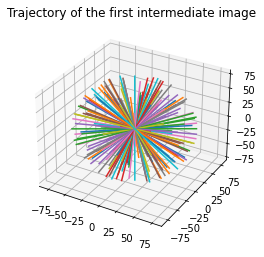

<Figure size 432x288 with 0 Axes>

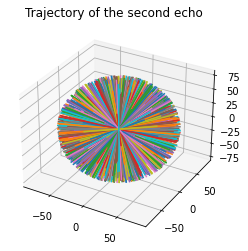

In [11]:
# %%*********************************************************************
# Display the trajectory for any intermediate image or any echo image 
#*************************************************************************
# first intermediate image 
plt.figure()
plot_traj(final_traj,1,0,nEchoes, nProjections,nTR)
plt.title('Trajectory of the first intermediate image')
# second echo image 
plt.figure()
plot_traj(final_traj,0,1,nEchoes, nProjections,nTR)
plt.title('Trajectory of the second echo ')

